# Monte Carlo Tree Search (MCTS) aided by Acto-Critic RL Agent (alphazero)

## To play with a pretrained model, jump straight to step 3, to train the alphazero agent follow the steps below

### Step 1. Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import *
import numpy as np
import random

### Step 2. Training Loop

The alphazero loss function is defined as
$$L = \sum_t \left\{ (v^{(t)}_\theta - z)^2  - \sum_a p^{(t)}_a \log \pi_\theta(a|s_t) \right\} + \textrm{constant}$$ 


In [2]:
# train our agent

from ConnectN import ConnectN
from Policy_NN import Policy

from collections import deque
import MCTSwithRL

# initialize alphazero agent and optimizer
import torch.optim as optim

episodes = 1500 #500
outcomes = []
losses = []

game_setting = {'size':(3,3), 'N':3}

!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episodes).start()

policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=.01, weight_decay=1.e-4)

for e in range(episodes):
    mytree = MCTSwithRL.Node(ConnectN(**game_setting))
    vterm = []
    logterm = []
    
    while mytree.outcome is None:
        for _ in range(300): # 50 #explore the Tree 250 steps
            mytree.explore(policy)

        current_player = mytree.game.player
        mytree, (v, nn_v, p, nn_p) = mytree.next() #The tree will choose an action based on the visit counts     
                                                   # (v, nn_v, p, nn_p) are the outputs used to update the Policy
                                                   # v is the expected outcome computed from the Tree search, but it will not be useful here
                                                   # nn_v is the critic value evaluating the current board
                                                   # p is the least of probability of taking each action computed from MCTS
                                                   # nn_p is same as p without MCTS, basically coming straight from the Policy
        mytree.detach_mother() #This is required because now, the next node is the base node, need to start MCTree from scratch
        
        # compute prob* log pi 
        loglist = torch.log(nn_p)*p
        
        # constant term to make sure if policy result = MCTS result, loss = 0
        constant = torch.where(p>0, p*torch.log(p),torch.tensor(0.))
        logterm.append(-torch.sum(loglist-constant))
        
        vterm.append(nn_v*current_player)
        
        
    # we compute the "policy_loss" for computing gradient
    outcome = mytree.outcome
    outcomes.append(outcome)
    
    # solution
    loss = torch.sum( (torch.stack(vterm)-outcome)**2 + torch.stack(logterm) )
    optimizer.zero_grad()
    
    loss.backward()
    losses.append(float(loss))
    optimizer.step()
    
    if (e+1)%50==0:
        print("game: ",e+1, ", mean loss: {:3.2f}".format(np.mean(losses[-20:])),
              ", recent outcomes: ", outcomes[-10:])
    del loss
    
    timer.update(e+1)
    
    
timer.finish()

torch.save(policy.state_dict(), 'Policy_alphazero_tictactoe.pth')

print("training complete, model saved")


/Users/tamoghnadas/github_new/RL_Projects_my_own/alphazero-TicTacToe/MCTSwithRL.py:71: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/IndexingUtils.h:28.)
  return game.available_moves(), tinv(prob)[mask].view(-1), v.squeeze().squeeze()#reverse rot/reflection is applied on prob
/Users/tamoghnadas/opt/anaconda3/envs/pytorch1/lib/python3.8/site-packages/torch/autograd/__init__.py:197: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/IndexingUtils.h:28.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


game:  50 , mean loss: 6.13 , recent outcomes:  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


game:  100 , mean loss: 3.54 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


game:  150 , mean loss: 3.72 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


game:  200 , mean loss: 0.52 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


game:  250 , mean loss: 0.78 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


game:  300 , mean loss: 0.86 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


game:  350 , mean loss: 0.94 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


game:  400 , mean loss: 1.11 , recent outcomes:  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


game:  450 , mean loss: 0.27 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


game:  500 , mean loss: 0.15 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


game:  550 , mean loss: 0.13 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


game:  600 , mean loss: 0.05 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


game:  650 , mean loss: 0.12 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


game:  700 , mean loss: 0.09 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


game:  750 , mean loss: 0.14 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


game:  800 , mean loss: 0.24 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


game:  850 , mean loss: 0.35 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


game:  900 , mean loss: 0.18 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


game:  950 , mean loss: 0.55 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


game:  1000 , mean loss: 1.44 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, -1, 0]


game:  1050 , mean loss: 0.24 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


game:  1100 , mean loss: 0.06 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


game:  1150 , mean loss: 0.05 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


game:  1200 , mean loss: 0.09 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


game:  1250 , mean loss: 0.17 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


game:  1300 , mean loss: 1.35 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


game:  1350 , mean loss: 0.08 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


game:  1400 , mean loss: 0.03 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


game:  1450 , mean loss: 0.06 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


game:  1500 , mean loss: 0.08 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
training complete, model saved


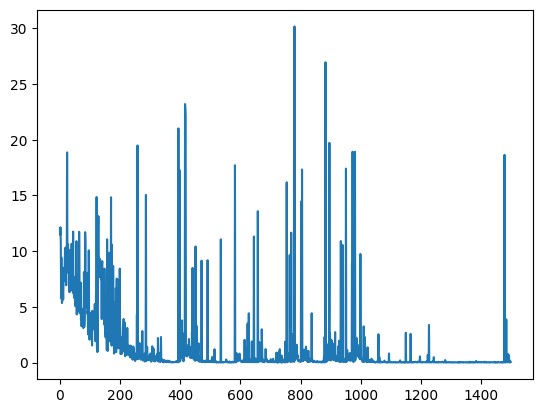

In [5]:
# plot losses

import matplotlib.pyplot as plt

%matplotlib inline
plt.plot(losses)
plt.show()


### Step3 - Play a game against the alphazero agent !

#### Define a player that uses MCTS and the expert policy + critic to play a game

We've introduced a new parameter
$T$ = temperature

This tells us how to choose the next move based on the MCTS results

$$p_a = \frac{N_a^{\frac{1}{T}}}{\sum_a N_a^{\frac{1}{T}}}$$

$T \rightarrow 0$, we choose action with largest $N_a$. 

#### Define a RL player

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import *
import numpy as np
import random

import MCTSwithRL # MCTS aided by Actor-Critic RL

from Policy_NN import Policy

from copy import copy
import random

# load the weights from file
policy_alphazero = Policy()
policy_alphazero.load_state_dict(torch.load('Policy_alphazero_tictactoe.pth')) 

# Two players are defined below, Policy_Player_MCTS is the MCTS player,
# Random_Player is a random move playing player

def Policy_Player_MCTS(game):
    tree = MCTSwithRL.Node(copy(game))
    for _ in range(50): # explore the tree 50 steps #50
        tree.explore(policy_alphazero) # This will compute all the U s, pick the branch with max U, search, 
                               # expand, backpropagate and increase the visit count
   
    treenext, (v, nn_v, p, nn_p) = tree.next(temperature=0.1) # Asking the tree to choose a next move based on the visit counts
        
    return treenext.game.last_move # returns the move after incrementing the Tree

def Random_Player(game):
    return random.choice(game.available_moves())

#### Alphazero agent as second player

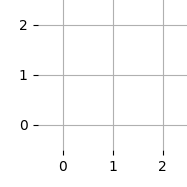

In [8]:
from ConnectN import ConnectN
game_setting = {'size':(3,3), 'N':3}
#%matplotlib notebook
%matplotlib widget

from Play import Play

# as first player
gameplay=Play(ConnectN(**game_setting), 
              player1=None, 
              player2=Policy_Player_MCTS)


#### Alphazero agent as first player

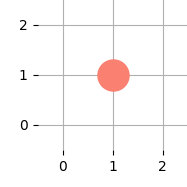

In [9]:
from ConnectN import ConnectN

game_setting = {'size':(3,3), 'N':3}
#%matplotlib notebook
%matplotlib widget

from Play import Play

# as second player
gameplay=Play(ConnectN(**game_setting), 
              player2=None, 
              player1=Policy_Player_MCTS)


#### Alphazero vs Alphazero

In [10]:
from ConnectN import ConnectN

game_setting = {'size':(3,3), 'N':3}
#%matplotlib notebook
%matplotlib widget

from Play import Play

# as second player
gameplay=Play(ConnectN(**game_setting), 
              player1=Policy_Player_MCTS, 
              player2=Policy_Player_MCTS)